In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
%matplotlib inline

### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  We said that for a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  Let's work it out:

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

### Gradient boosting with regression trees

The loss function to minimize is the sum of the squared residuals:

$$\frac1{n}\sum_{i=1}^n(y_i-(\alpha + \beta x_i))^2$$

(Though it can also be the sum of the absolute value of the residuals, as in lasso regression.)

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

The decision trees we use can be very simple.  In the example below, the decision trees only have a max depth of 2, meaning a maximum of four leaves.  These weak learners do not have to perform well at all individually in order to do well in aggregate.  

Here we're going to do gradient boosting with regression trees by hand.  Our goal is to predict the variable "happy" using all the other variables in the European Social Survey dataset.  We'll calculate a tree, store the predicted values, pull the residuals, and run a new tree on the residuals.  This will repeat 101 times.  At the end, we add together all the predicted values from each iteration to yield the final predictions.

Weak learner 0 R^2: -21.86595826514709
Weak learner 20 R^2: -0.0026192923008196978
Weak learner 40 R^2: -0.0016748172727343302
Weak learner 60 R^2: -0.0014818633549413818
Weak learner 80 R^2: -0.0012578370480087475
Weak learner 100 R^2: -0.0007136861925907123


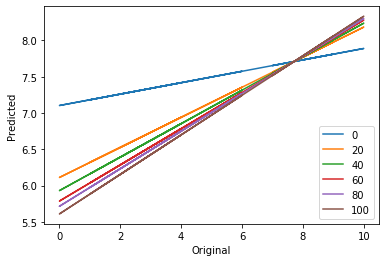

Overall R^2:
0.5282873581794292


In [2]:
# Working with the European Social Survey data again.
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Define outcome and predictors.
y = df['happy']
X = df.loc[:, ~df.columns.isin(['happy', 'cntry'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Store values from loops.
preds = pd.DataFrame()
labels = []

uniquex = df['happy'].unique()

# Iterate through decision trees, each time using the residuals
# from the previous tree as the inputs.
for m in range(0, 101):
    
    # Initialize and fit the tree. Set the max depth to 2.
    decision_tree = tree.DecisionTreeRegressor(max_depth=2)
    decision_tree.fit(X,y)
    
    # Get and store predicted values.
    pred = decision_tree.predict(X)
    preds['pred{}'.format(m)] = pred
    
    # Residuals.
    y = y - pred

    # Output every 20 iterations.
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, decision_tree.score(X, y)))
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(df['happy'], bestpred, 1))(uniquex))
       
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds.sum(axis=1)

print('Overall R^2:')
# Pearson product-moment correlation
print(np.corrcoef(df['happy'], predicted)[0, 1])

In [4]:
preds.head()

,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,...,pred91,pred92,pred93,pred94,pred95,pred96,pred97,pred98,pred99,pred100
0,8.168311,0.013769,-0.029901,0.181363,0.104414,-0.030160,-0.120018,-0.013159,0.301909,-0.002564,...,-0.012236,0.015056,-0.012845,0.001085,-0.008118,0.002566,-0.010875,-0.001109,-0.202222,0.235428
1,7.633021,0.013769,-0.029901,0.181363,-0.235860,0.163699,-0.120018,-0.013159,-0.008157,-0.002564,...,-0.012236,0.015056,-0.012845,0.001085,0.074060,0.002566,-0.010875,-0.001109,-0.202222,0.235428
2,8.168311,0.198944,0.434040,0.520883,0.104414,-0.000255,0.136552,-0.013159,-0.008157,-0.183307,...,-0.012236,0.015056,-0.012845,0.001085,-0.008118,0.002566,0.044827,0.011030,-0.202222,0.235428
3,7.633021,0.389182,-0.029901,0.181363,-0.235860,0.163699,0.076182,-0.013159,-0.008157,-0.002564,...,-0.012236,0.015056,-0.012845,0.001085,-0.008118,0.002566,-0.010875,-0.001109,-0.001848,0.235428
4,7.633021,0.389182,-0.029901,0.181363,-0.235860,0.163699,-0.120018,-0.013159,-0.008157,0.096519,...,-0.012236,0.015056,-0.012845,0.001085,-0.008118,0.002566,-0.010875,-0.001109,-0.001848,0.235428


Looking at the sampling of individual model $R^2$, these are certainly 'weak learners'!  They perform very badly indeed.  Yet in aggregate, the models are able to explain nearly 53% of the variance in happiness in the dataset.  This is a great example of the power of gradient boosting.  You may also note from the plot that the greatest gains happened in the earliest models, with subsequent steps yielding smaller gains in explanatory power.

But maybe we could do just as well with one big decision tree, rather than a bunch of small ones.  Let's try:

In [3]:
# One big tree. Each node split will include at lest 2.5% of the total sample.
decision_tree = tree.DecisionTreeRegressor(min_samples_split=.025)
decision_tree.fit(X,y)

#Get and store predicted values.
pred = decision_tree.predict(X)
print('One strongish learner R^2: {}'.format(decision_tree.score(X, y)))

dot_data = tree.export_graphviz(decision_tree, out_file=None,
                                feature_names=X.columns,  
                                filled=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())  

One strongish learner R^2: 0.06711108322936532


InvocationException: GraphViz's executables not found

Well that didn't work at all.  Gradient boosting with weak learners was nearly 10 times more effective as one complex decision tree.  In fact, in many instances gradient boosted decision trees perform better than random forests.  They are also less prone to overfitting than individual decision trees.

### Overfitting

Still, it is easy to see that the more iterations we run, the more likely we are to overfit.  Gradient boost comes with some methods to avoid overfitting.  Cross-validation will check for overfitting, but there are also methods that can be applied before using the test set that will reduce the likelihood of overfit.  

One option is subsampling, where each iteration of the boost algorithm uses a subsample of the original data.  By introducing some randomness into the process, subsampling makes it harder to overfit.

Another option is shrinkage, which we have encountered before in ridge regression.  Here, the shrinkage/regularization parameter reduces the impact of subsequent iterations on the final solution.  Visually, you can picture this parameter, called the "learning rate", causing each "step" along the loss function gradient to be a little smaller than the previous one.  This prevents any one iteration from being too influential and misdirecting the overall boost solution.  Learning rates vary between 0 (only the initial iteration matters) to 1 (all iterations are weighted equally).  A model made up of many small steps is less prone to overfitting than a model made up of few large steps, but it can also lead to much slower running times, depending on the stopping rule in play.

In the next assignment, we'll try gradient boosting using the SKLearn package, which comes with all sorts of helpful features for getting the most out of gradient boost.